In [ ]:
!pip install pyspark

# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Diabetes Prediction").getOrCreate()

# Load dataset
file_path = "/content/diabetes_prediction_dataset.csv"  # Replace with the path to your dataset
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Display schema and preview data
data.printSchema()
data.show(5)

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                15

In [ ]:
#Preprocessing

In [ ]:
# Summary statistik
data.describe().show()

+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|  count|100000|           100000|            100000|            100000|         100000|           100000|            100000|             100000|             100000|
|   mean|  NULL|41.88585600000013|           0.07485|           0.03942|           NULL|27.32076709999422|5.5275069999983275|          138.05806|              0.085|
| stddev|  NULL|22.51683987161704|0.2631504702289171|0.1945930169980986|           NULL|6.636783416648357|1.0706720918835468|  40.70813604870383|0.27888308976661896|
|   

+------+------------+---------------+---------------------+--------------------+
|gender|gender_index|smoking_history|smoking_history_index|            features|
+------+------------+---------------+---------------------+--------------------+
|Female|         0.0|          never|                  1.0|[0.0,80.0,0.0,1.0...|
|Female|         0.0|        No Info|                  0.0|(8,[1,5,6,7],[54....|
|  Male|         1.0|          never|                  1.0|[1.0,28.0,0.0,0.0...|
|Female|         0.0|        current|                  3.0|[0.0,36.0,0.0,0.0...|
|  Male|         1.0|        current|                  3.0|[1.0,76.0,1.0,1.0...|
+------+------------+---------------+---------------------+--------------------+
only showing top 5 rows



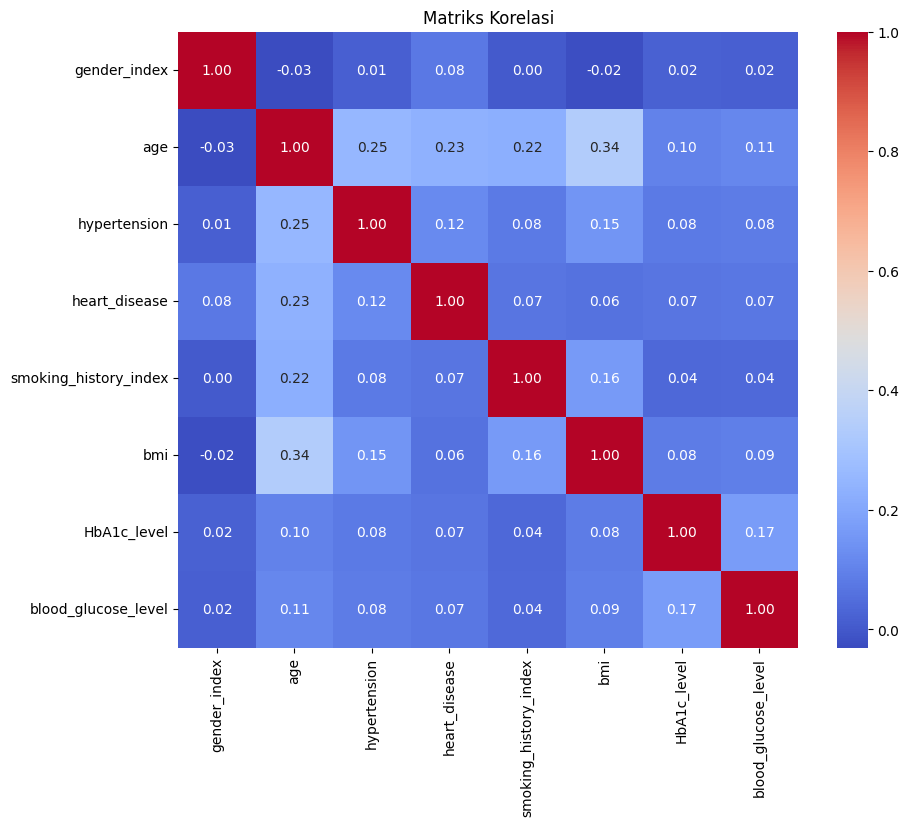

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

# Melakukan encoding pada kolom kategorikal
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
smoking_history_indexer = StringIndexer(inputCol="smoking_history", outputCol="smoking_history_index")

# Kolom fitur yang akan digabungkan
feature_cols = ["gender_index", "age", "hypertension", "heart_disease",
                "smoking_history_index", "bmi", "HbA1c_level", "blood_glucose_level"]

# Membuat VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Membuat pipeline
pipeline = Pipeline(stages=[gender_indexer, smoking_history_indexer, assembler])

# Menjalankan pipeline
data_transformed = pipeline.fit(data).transform(data)

# Menampilkan hasil encoding dan fitur vektor
data_transformed.select("gender", "gender_index", "smoking_history", "smoking_history_index", "features").show(5)

# Membuat fitur vektor
data_vector = data_transformed.select("features")

# Menghitung matriks korelasi
correlation_matrix = Correlation.corr(data_vector, "features").head()[0]
correlation_array = correlation_matrix.toArray()

# Membuat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_array, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=feature_cols, yticklabels=feature_cols)
plt.title("Matriks Korelasi")
plt.show()


<ipython-input-55-fd16a1feeac9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_dist, x="gender", y="count", palette="viridis")


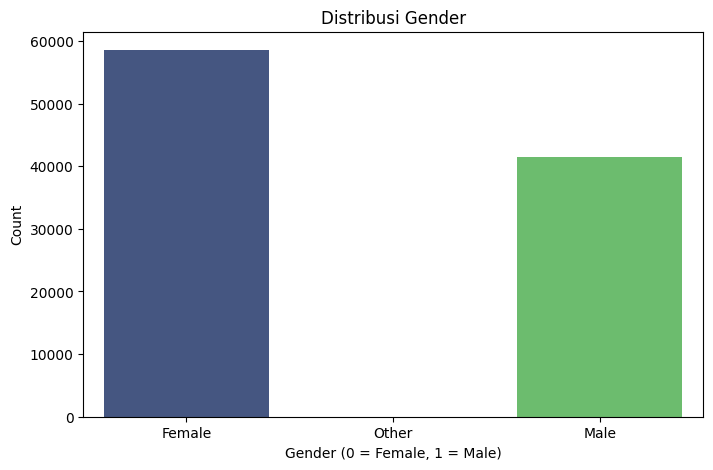

In [ ]:
# Mengambil data distribusi gender
gender_dist = data.groupBy("gender").count().toPandas()

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(data=gender_dist, x="gender", y="count", palette="viridis")
plt.title("Distribusi Gender")
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Count")
plt.show()

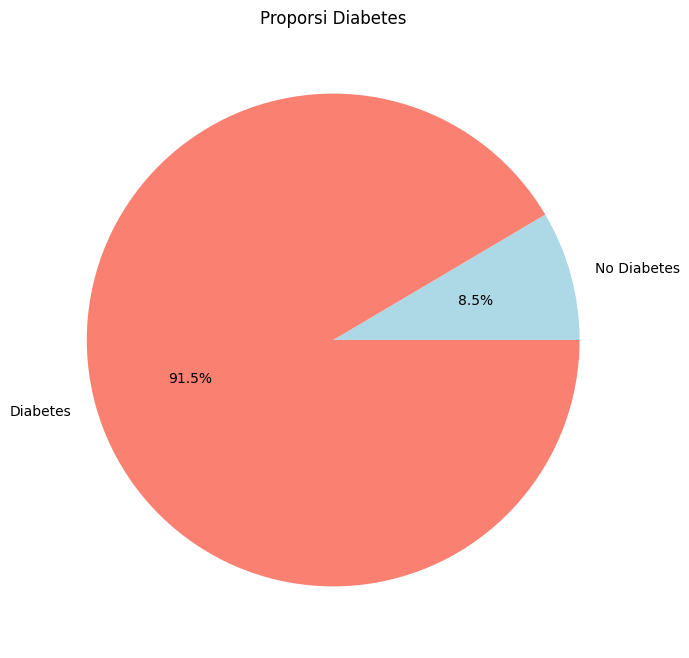

In [ ]:
# Mengambil data distribusi diabetes
diabetes_dist = data.groupBy("diabetes").count().toPandas()

# Visualisasi
plt.figure(figsize=(8, 8))
plt.pie(diabetes_dist["count"], labels=["No Diabetes", "Diabetes"], autopct="%1.1f%%", colors=["lightblue", "salmon"])
plt.title("Proporsi Diabetes")
plt.show()

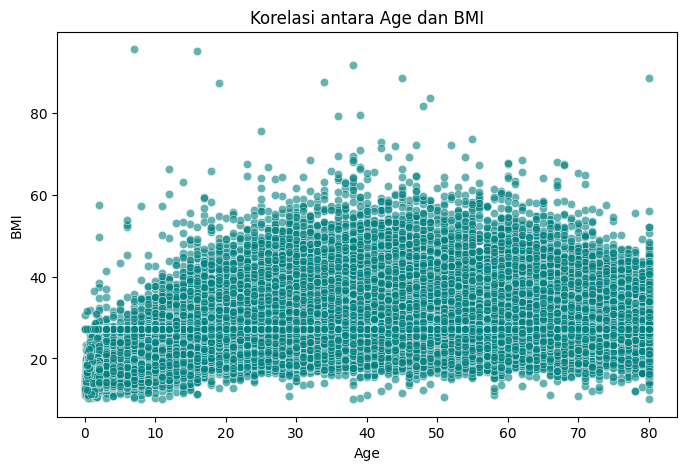

In [ ]:
# Mengambil data
scatter_data = data.select("age", "bmi").toPandas()

# Visualisasi
plt.figure(figsize=(8, 5))
sns.scatterplot(data=scatter_data, x="age", y="bmi", alpha=0.6, color="teal")
plt.title("Korelasi antara Age dan BMI")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.show()

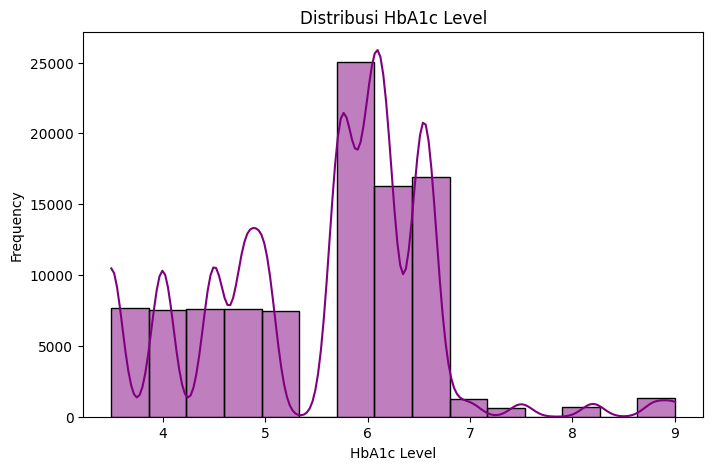

In [ ]:
# Mengambil data
hba1c_data = data.select("HbA1c_level").toPandas()

# Visualisasi
plt.figure(figsize=(8, 5))
sns.histplot(hba1c_data["HbA1c_level"], bins=15, kde=True, color="purple")
plt.title("Distribusi HbA1c Level")
plt.xlabel("HbA1c Level")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Membagi data menjadi data pelatihan (train) dan data pengujian (test)
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Inisialisasi model
rf = RandomForestClassifier(featuresCol="features", labelCol="diabetes")
gbt = GBTClassifier(featuresCol="features", labelCol="diabetes", maxIter=10)
lr = LogisticRegression(featuresCol="features", labelCol="diabetes")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="diabetes")

# Latih model dan evaluasi
models = {"Random Forest": rf, "Gradient Boosted Trees": gbt, "Logistic Regression": lr, "Decision Tree": dt}
evaluator = BinaryClassificationEvaluator(labelCol="diabetes", metricName="areaUnderROC")

for name, model in models.items():
    trained_model = model.fit(train_data)  # Latih model dengan data pelatihan
    predictions = trained_model.transform(test_data)  # Prediksi dengan data pengujian
    auc = evaluator.evaluate(predictions)  # Evaluasi AUC
    print(f"{name} AUC: {auc:.4f}")


Random Forest AUC: 0.9551
Gradient Boosted Trees AUC: 0.9721
Logistic Regression AUC: 0.9602
Decision Tree AUC: 0.6230


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Menggunakan StringIndexer untuk mengubah kolom 'smoking_history' menjadi numerik
# Memeriksa jika kolom 'smoking_history_index' sudah ada, dan mengganti nama output jika diperlukan
if "smoking_history_index" in data.columns:
    data = data.drop("smoking_history_index")

indexer_smoking_history = StringIndexer(inputCol="smoking_history", outputCol="smoking_history_index")
data = indexer_smoking_history.fit(data).transform(data)

# Menggunakan StringIndexer untuk mengubah kolom target 'diabetes' menjadi numerik
# Memeriksa jika kolom 'label_index' sudah ada, dan mengganti nama output jika diperlukan
if "label_index" in data.columns:
    data = data.drop("label_index")

indexer = StringIndexer(inputCol="diabetes", outputCol="label_index")  # Ganti outputCol menjadi 'label_index'
data = indexer.fit(data).transform(data)

# Menyiapkan fitur
feature_cols = ["age", "hypertension", "heart_disease", "smoking_history_index", "bmi", "HbA1c_level", "blood_glucose_level"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

# Membagi dataset menjadi training dan testing
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Membuat model evaluasi untuk klasifikasi
evaluator = BinaryClassificationEvaluator(labelCol="label_index")

# Random Forest model
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features")

# Hyperparameter tuning for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator, numFolds=3)
best_rf_model = cv_rf.fit(train_data).bestModel

# Gradient Boosted Trees model
gbt = GBTClassifier(labelCol="label_index", featuresCol="features")

# Hyperparameter tuning for Gradient Boosted Trees
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .build()

cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid_gbt, evaluator=evaluator, numFolds=3)
best_gbt_model = cv_gbt.fit(train_data).bestModel


In [ ]:
# Evaluate the best models
best_rf_preds = best_rf_model.transform(test_data)
best_gbt_preds = best_gbt_model.transform(test_data)

best_rf_auc = evaluator.evaluate(best_rf_preds)
best_gbt_auc = evaluator.evaluate(best_gbt_preds)

print(f"Best Random Forest AUC: {best_rf_auc:.4f}")
print(f"Best Gradient Boosted Trees AUC: {best_gbt_auc:.4f}")

Best Random Forest AUC: 0.9739
Best Gradient Boosted Trees AUC: 0.9801
